### Volatility Forecasting

This is the capstone project of Mert Karsiyakalilar for the Udacity Machine Learning Engineer NanoDegree

In [78]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# _ preferences
plt.rcParams['figure.figsize'] = (30.0, 10.0)
plt.style.use('ggplot')

# _ get equity prices + volume
eq = web.DataReader("AAPL", "quandl", "1990-01-01", "2017-12-19")
eq.sort_index(inplace=True)
eq = eq[["AdjOpen", "AdjHigh", "AdjLow", "AdjClose", "AdjVolume"]]

Raw data distributions

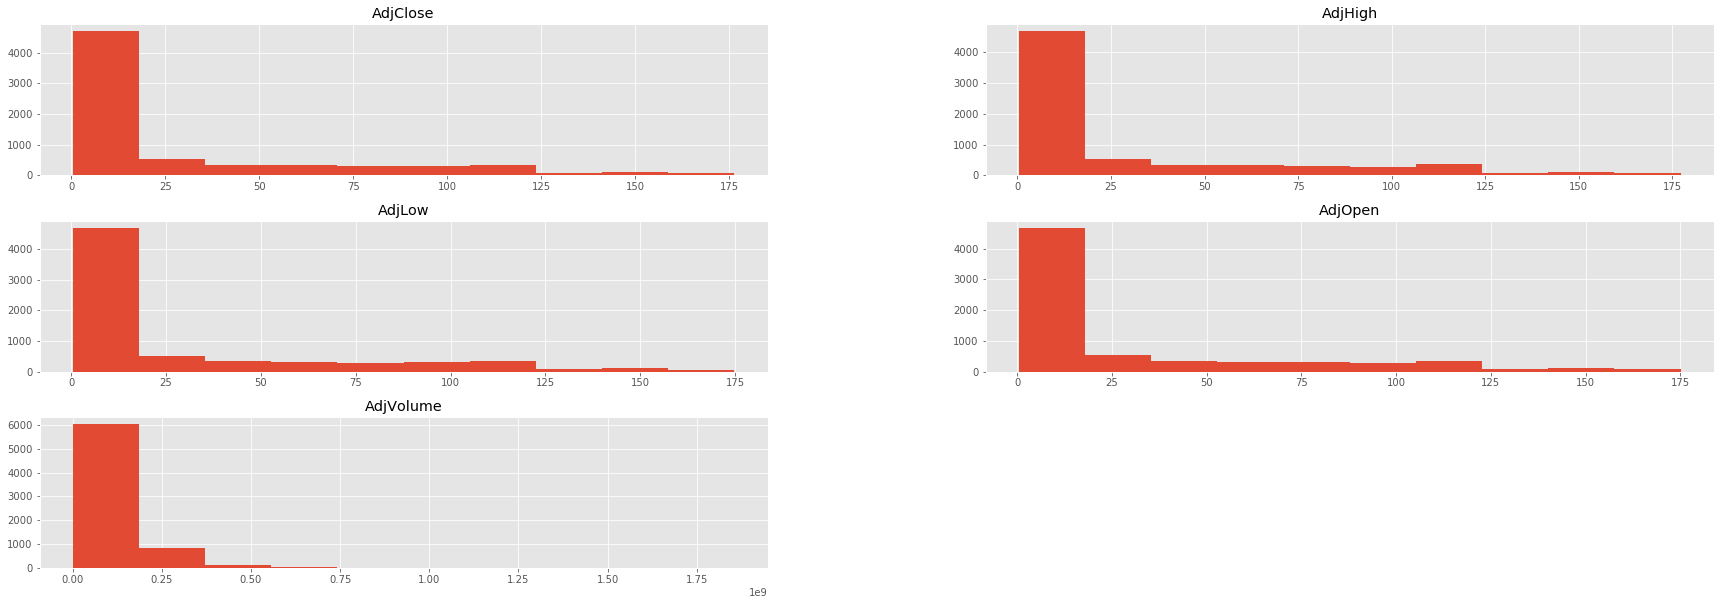

In [79]:
eq.hist()
plt.show()

Normalizing the raw data

In [67]:
# _ normalize the features
WINDOW_SIZE = 5
# norm_eq = (eq - eq.rolling(WINDOW_SIZE).mean()) / eq.rolling(WINDOW_SIZE).std()
norm_eq = eq[["AdjOpen", "AdjHigh", "AdjLow", "AdjClose"]].pct_change()
norm_eq.replace([np.inf, -np.inf], np.nan, inplace=True)
norm_eq["AdjVolume"] = np.log(eq["AdjVolume"]).pct_change()
norm_eq.fillna(0., inplace=True)

# norm_eq["AdjVolume"] = np.log(norm_eq["AdjVolume"])

# _ add rolling window returns to the features
RETURN_WINDOW = 5 
returns = eq['AdjClose'].pct_change()
returns.name = "returns"

# _ calculate observed volatility
volatility = returns.rolling(RETURN_WINDOW).std()
volatility.name = "ex_post_volatility"

# _ shift observed volatility to create target volatilities
FORECAST_WINDOW = 5
lookahead_volatility = volatility.shift(-FORECAST_WINDOW)
lookahead_volatility.name = 'ex_ante_volatility'

# _ only use ranges, returns and volatility as feaures and lookahead volatility as the target
input_data = pd.concat([norm_eq, volatility, lookahead_volatility], axis=1).dropna()


Distributions after normalization

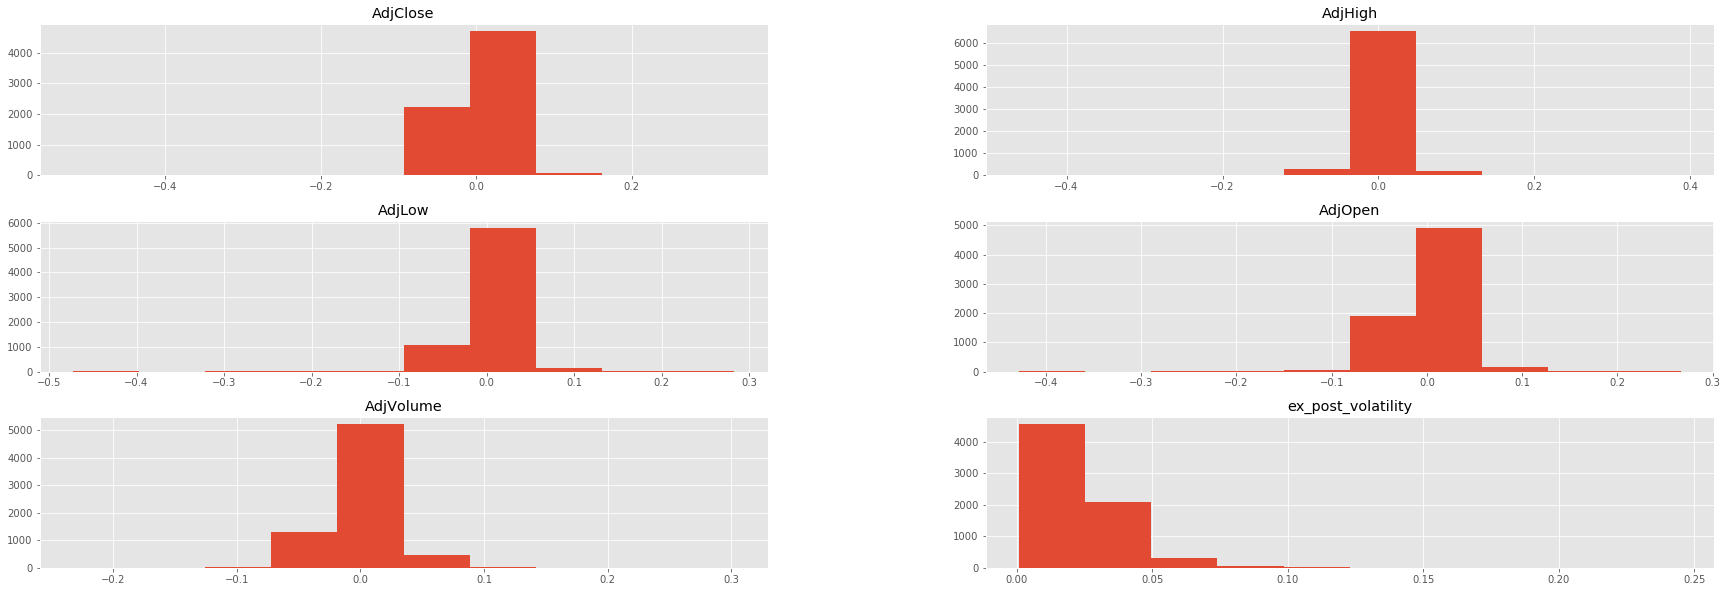

In [80]:
input_data[['AdjClose', 'AdjHigh', 'AdjLow', 'AdjOpen', 'AdjVolume', 'ex_post_volatility']].hist()
plt.show()

Formatting input data to have embedding layers

In [41]:
X = input_data[['AdjOpen', 'AdjHigh', 'AdjLow', 'AdjClose', 'AdjVolume', 'ex_post_volatility']]
Y = input_data['ex_ante_volatility']

def normalize_data(X, Y, LOOKBACK_WINDOW):
    _X = X.dropna()
    _Xs = []
    _Ys = []
    for i in range(_X.shape[0] - LOOKBACK_WINDOW):
        cur_X = _X.values[i:i + LOOKBACK_WINDOW]
        _Xs.append(cur_X)
        
        y_pointer = i + LOOKBACK_WINDOW
        cur_Y = Y.values[y_pointer]
        _Ys.append(cur_Y)
    return np.array(_Xs), np.array(_Ys)

x, y = normalize_data(X, Y, 30)

x_train, x_test = x[:int(len(x) * .9)], x[int(len(x) * .9):]
y_train, y_test = y[:int(len(y) * .9)], y[int(len(y) * .9):]

Building a linear benchmark model

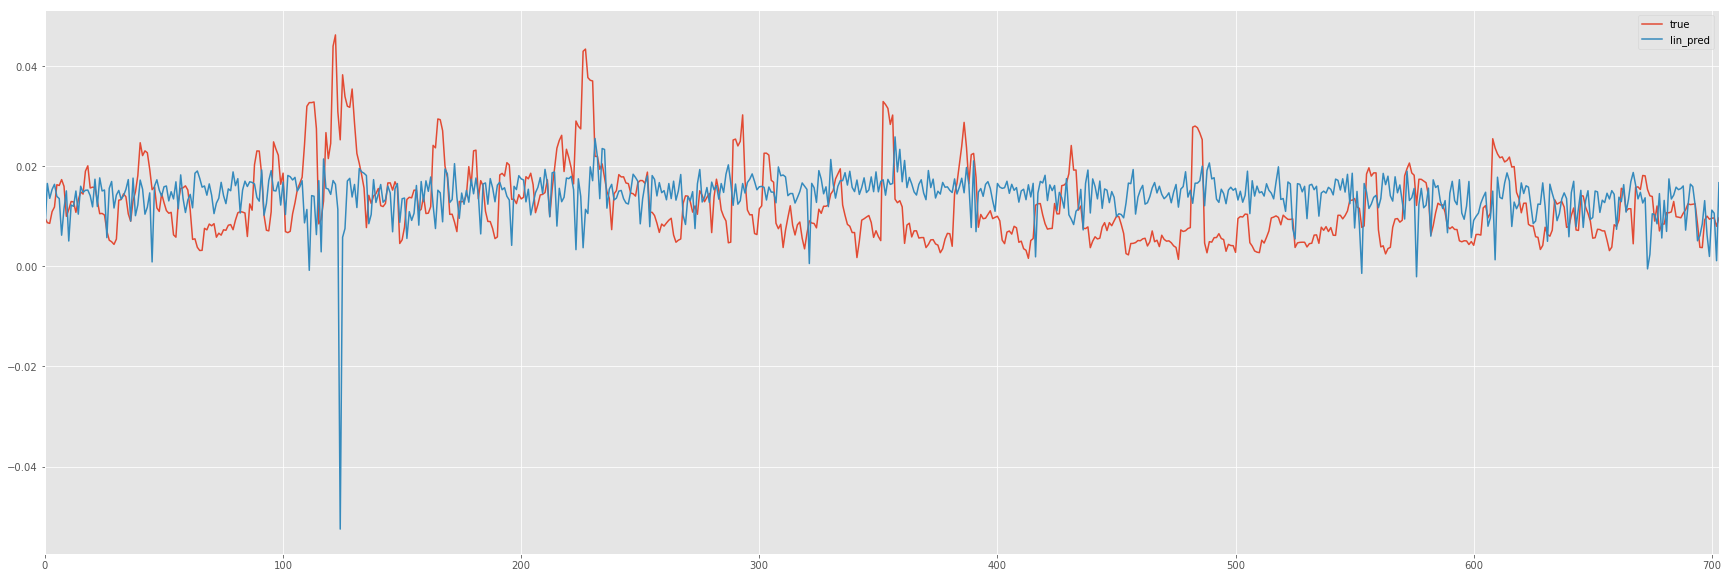

In [7]:
# _ build a linear model
from sklearn.linear_model import LogisticRegression

lin_reg = LinearRegression()

lin_X = X.dropna()
lin_Y = Y.dropna()


train_end = int(X.shape[0] * .9)

lin_X_train, lin_X_test = lin_X[:train_end], lin_X[train_end:]
lin_Y_train, lin_Y_test = lin_Y[:train_end], lin_Y[train_end:]

# _  fit the model
lin_reg.fit(lin_X_train, lin_Y_train)

# _ make predictions
lin_pred = lin_reg.predict(lin_X_test)

# _ show results
lin_df = pd.DataFrame(np.column_stack([lin_Y_test, lin_pred]), columns=["true", "lin_pred"])
lin_df.plot()
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error

In [81]:
mean_squared_error(lin_Y_test, lin_pred)

8.0768333011583258e-05

Importing keras and building an initial LSTM model

In [70]:
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute
from keras.layers import Merge, Input, concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses

# _ build the model
d = .5

_data_shape = (30, 6)

model = Sequential()
model.add(LSTM(128, input_shape=_data_shape, return_sequences=False))
model.add(Dropout(d))
model.add(Dense(16, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))

opt = Nadam(lr=0.002, clipnorm = .1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="model_returns.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=opt, loss='mse')

In [71]:
# _ fit the model
history = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=10,
    validation_split=0.1,
    callbacks=[reduce_lr, checkpointer],
    verbose=1)

Train on 5675 samples, validate on 631 samples
Epoch 1/10
5675/5675 [==============================] - 37s 7ms/step - loss: 2.8159e-04 - val_loss: 1.5198e-04
Epoch 2/10
5675/5675 [==============================] - 36s 6ms/step - loss: 2.5648e-04 - val_loss: 7.0491e-05
Epoch 3/10
5675/5675 [==============================] - 36s 6ms/step - loss: 2.4974e-04 - val_loss: 1.8582e-04
Epoch 4/10
5675/5675 [==============================] - 36s 6ms/step - loss: 2.4545e-04 - val_loss: 1.2636e-04
Epoch 5/10
5675/5675 [==============================] - 36s 6ms/step - loss: 2.4766e-04 - val_loss: 1.7633e-04
Epoch 6/10
5675/5675 [==============================] - 36s 6ms/step - loss: 2.4766e-04 - val_loss: 9.6170e-05
Epoch 7/10
5675/5675 [==============================] - 35s 6ms/step - loss: 2.4002e-04 - val_loss: 8.9036e-05
Epoch 8/10
5675/5675 [==============================] - 36s 6ms/step - loss: 2.4344e-04 - val_loss: 6.7067e-05
Epoch 9/10
5675/5675 [==============================] - 36s 6ms/s

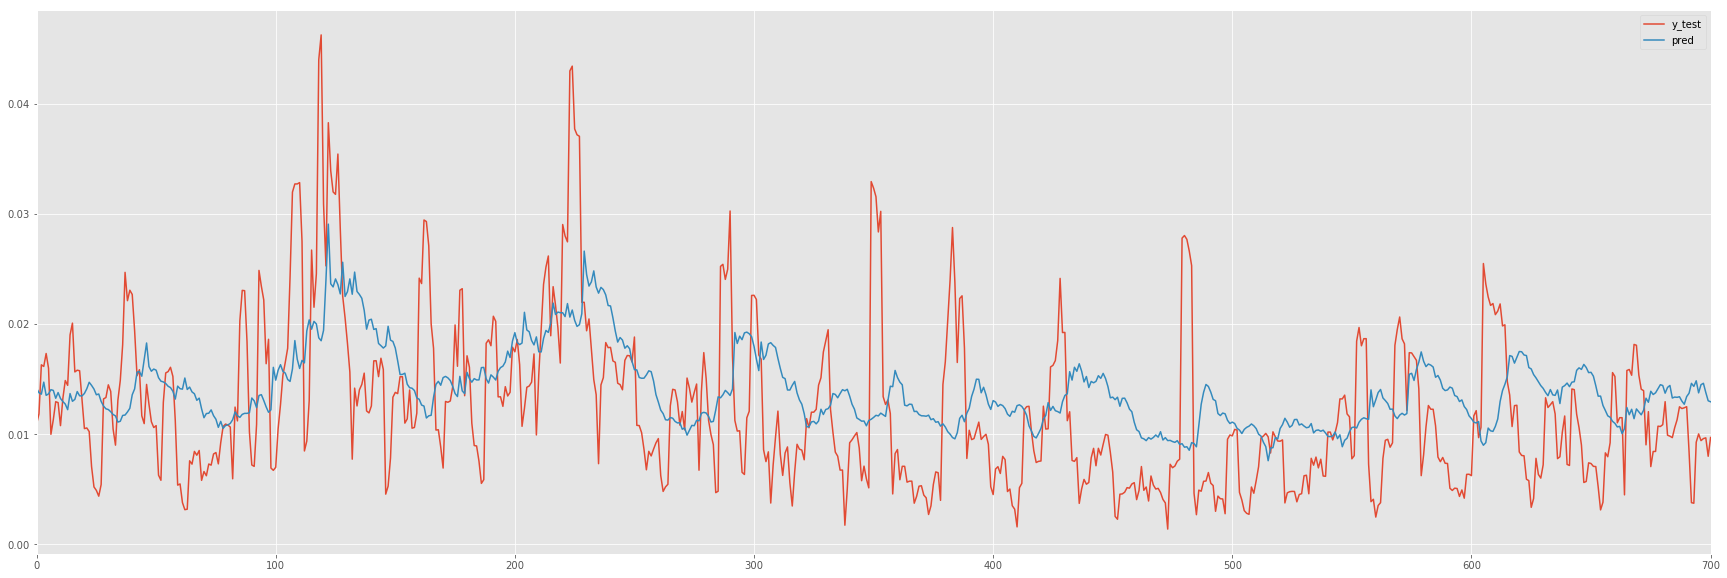

In [72]:
# _ load the model and make predictions
model.load_weights("model_returns.hdf5")
y_pred = model.predict(x_test)
pred_df = pd.DataFrame(np.column_stack([y_test, y_pred]), columns=["y_test", "pred"])

# _ show results
pred_df.plot()
plt.show()

In [83]:
score = model.evaluate(x_test, y_test, batch_size=16)

701/701 [==============================] - 1s 1ms/step


In [84]:
score

5.076254699987023e-05

In [82]:
mean_squared_error(y_test, y_pred) 

5.0762546538954758e-05

Hyper-parameter optimizations

In [93]:
lstm_sizes = [32, 64, 128]
dense_sizes = [16, 32, 64]
batch_sizes = [16, 64, 256]
input_shape = (30, 6)
epochs = [10, 20]

def parameter_optimization(lstm_sizes, dense_sizes, batch_sizes, epochs, input_shape, x_train, x_test, y_train, y_test):
    """
      returns a dictionary of model parameters and MSE score
    """
    scores = []
  
    # _ build the model
    for lstm_size in lstm_sizes:
        
        model = Sequential()
        model.add(LSTM(lstm_size, input_shape=input_shape, return_sequences=False))
        model.add(Dropout(.5))

        for dense_size in dense_sizes:
        
            model.add(Dense(dense_size, kernel_initializer='uniform', activation='relu'))
            model.add(Dense(1, kernel_initializer='uniform', activation='linear'))

            for batch_size in batch_sizes:
                for n_epochs in epochs:
                    # _ train the model
                    model_name = "LSTM_size{}_Dense_size{}_batch_size{}_epochs{}.hdf5".format(lstm_size, dense_size, batch_size, n_epochs)
                    print("## RUNNING MODEL: {}".format(model_name))
                    try:
                        opt = Nadam(lr=0.002, clipnorm = .1)

                        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
                        checkpointer = ModelCheckpoint(monitor='val_loss', filepath=model_name, verbose=1, save_best_only=True)

                        model.compile(optimizer=opt, loss='mse')
                        history = model.fit(
                            x_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=n_epochs,
                            validation_split=0.1,
                            callbacks=[reduce_lr, checkpointer],
                            verbose=1)

                        # _ evaluate the model
                        score = model.evaluate(x_test, y_test, batch_size=batch_size)
                        scores.append({
                            "score": score,
                            "LSTM_size": lstm_size,
                            "Dense_size": dense_size,
                            "batch_size": batch_size,
                            "n_epochs": n_epochs
                        })
                    except:
                        print("## ERROR RUNNING MODEL: {}".format(model_name))
    return scores

grid_scores = parameter_optimization(lstm_sizes, dense_sizes, batch_sizes, epochs, input_shape, x_train, x_test, y_train, y_test)

## RUNNING MODEL: LSTM_size32_Dense_size16_batch_size16_epochs10.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/10
5675/5675 [==============================] - 37s 6ms/step - loss: 2.8502e-04 - val_loss: 1.9734e-04
Epoch 2/10
5675/5675 [==============================] - 33s 6ms/step - loss: 2.5736e-04 - val_loss: 1.4110e-04
Epoch 3/10
5675/5675 [==============================] - 34s 6ms/step - loss: 2.4770e-04 - val_loss: 1.0887e-04
Epoch 4/10
5675/5675 [==============================] - 33s 6ms/step - loss: 2.4374e-04 - val_loss: 7.3584e-05
Epoch 5/10
5675/5675 [==============================] - 33s 6ms/step - loss: 2.4329e-04 - val_loss: 8.3927e-05
Epoch 6/10
5675/5675 [==============================] - 33s 6ms/step - loss: 2.4328e-04 - val_loss: 8.7520e-05
Epoch 7/10
5675/5675 [==============================] - 38s 7ms/step - loss: 2.4163e-04 - val_loss: 1.5445e-04
Epoch 8/10
5675/5675 [==============================] - 34s 6ms/step - loss: 2.4078e-04 - val_loss: 1.4407

Epoch 2/10
5675/5675 [==============================] - 9s 2ms/step - loss: 2.1270e-04 - val_loss: 9.1704e-05
Epoch 3/10
5675/5675 [==============================] - 9s 2ms/step - loss: 2.0960e-04 - val_loss: 8.3204e-05
Epoch 4/10
5675/5675 [==============================] - 9s 2ms/step - loss: 2.0032e-04 - val_loss: 7.2977e-05
Epoch 5/10
5675/5675 [==============================] - 9s 2ms/step - loss: 1.9586e-04 - val_loss: 1.2359e-04
Epoch 6/10
5675/5675 [==============================] - 9s 2ms/step - loss: 2.2255e-04 - val_loss: 6.8103e-05
Epoch 7/10
5675/5675 [==============================] - 9s 2ms/step - loss: 2.0952e-04 - val_loss: 8.8557e-05
Epoch 8/10
5675/5675 [==============================] - 9s 2ms/step - loss: 2.0198e-04 - val_loss: 7.7283e-05
Epoch 9/10
5675/5675 [==============================] - 9s 2ms/step - loss: 1.9722e-04 - val_loss: 8.9013e-05
Epoch 10/10
701/701 [==============================] - 0s 270us/step
## RUNNING MODEL: LSTM_size32_Dense_size16_batch_si

Epoch 5/10
5675/5675 [==============================] - 2s 410us/step - loss: 1.6573e-04 - val_loss: 1.2992e-04
Epoch 6/10
5675/5675 [==============================] - 2s 387us/step - loss: 1.6788e-04 - val_loss: 1.0059e-04
Epoch 7/10
5675/5675 [==============================] - 2s 413us/step - loss: 1.6139e-04 - val_loss: 6.4733e-05
Epoch 8/10
5675/5675 [==============================] - 2s 422us/step - loss: 1.6502e-04 - val_loss: 6.5922e-05
Epoch 9/10
5675/5675 [==============================] - 2s 409us/step - loss: 1.6296e-04 - val_loss: 1.2057e-04
Epoch 10/10
701/701 [==============================] - 0s 83us/step
## RUNNING MODEL: LSTM_size32_Dense_size16_batch_size256_epochs20.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/20
5675/5675 [==============================] - 4s 759us/step - loss: 1.6260e-04 - val_loss: 9.4457e-05
Epoch 2/20
5675/5675 [==============================] - 2s 435us/step - loss: 1.6556e-04 - val_loss: 6.3655e-05
Epoch 3/20
5675/5675 [========

Epoch 8/10
5675/5675 [==============================] - 33s 6ms/step - loss: 1.8656e-04 - val_loss: 7.1307e-05
Epoch 9/10
5675/5675 [==============================] - 33s 6ms/step - loss: 2.0140e-04 - val_loss: 8.0383e-05
Epoch 10/10
701/701 [==============================] - 1s 1ms/step
## RUNNING MODEL: LSTM_size32_Dense_size32_batch_size16_epochs20.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/20
5675/5675 [==============================] - 36s 6ms/step - loss: 1.7025e-04 - val_loss: 7.9057e-05
Epoch 2/20
5675/5675 [==============================] - 34s 6ms/step - loss: 1.8020e-04 - val_loss: 7.8607e-05
Epoch 3/20
5675/5675 [==============================] - 34s 6ms/step - loss: 1.7275e-04 - val_loss: 8.2780e-05
Epoch 4/20
5675/5675 [==============================] - 34s 6ms/step - loss: 1.7361e-04 - val_loss: 7.4856e-05
Epoch 5/20
5675/5675 [==============================] - 34s 6ms/step - loss: 1.6194e-04 - val_loss: 7.4291e-05
Epoch 6/20
5675/5675 [=================

701/701 [==============================] - 0s 263us/step
## RUNNING MODEL: LSTM_size32_Dense_size32_batch_size64_epochs20.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/20
5675/5675 [==============================] - 11s 2ms/step - loss: 1.2692e-04 - val_loss: 8.6028e-05
Epoch 2/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.3210e-04 - val_loss: 7.2024e-05
Epoch 3/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.2473e-04 - val_loss: 7.3110e-05
Epoch 4/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.2400e-04 - val_loss: 7.5607e-05
Epoch 5/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.3653e-04 - val_loss: 7.7516e-05
Epoch 6/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.2511e-04 - val_loss: 8.2846e-05
Epoch 7/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.2721e-04 - val_loss: 1.3182e-04
Epoch 8/20
5675/5675 [==============================] -

Epoch 2/20
5675/5675 [==============================] - 2s 408us/step - loss: 1.0572e-04 - val_loss: 1.1100e-04
Epoch 3/20
5675/5675 [==============================] - 2s 401us/step - loss: 1.0719e-04 - val_loss: 8.1791e-05
Epoch 4/20
5675/5675 [==============================] - 2s 405us/step - loss: 1.0678e-04 - val_loss: 9.2547e-05
Epoch 5/20
5675/5675 [==============================] - 2s 411us/step - loss: 1.0398e-04 - val_loss: 7.1301e-05
Epoch 6/20
5675/5675 [==============================] - 2s 409us/step - loss: 1.0439e-04 - val_loss: 8.4210e-05
Epoch 7/20
5675/5675 [==============================] - 2s 408us/step - loss: 1.0634e-04 - val_loss: 7.1516e-05
Epoch 8/20
5675/5675 [==============================] - 2s 407us/step - loss: 1.0502e-04 - val_loss: 7.5531e-05
Epoch 9/20
5675/5675 [==============================] - 2s 397us/step - loss: 1.0699e-04 - val_loss: 1.0773e-04
Epoch 10/20
5675/5675 [==============================] - 2s 403us/step - loss: 1.0555e-04 - val_loss: 7.

Epoch 4/20
5675/5675 [==============================] - 35s 6ms/step - loss: 1.1797e-04 - val_loss: 9.9590e-05
Epoch 5/20
5675/5675 [==============================] - 35s 6ms/step - loss: 1.1720e-04 - val_loss: 8.7953e-05
Epoch 6/20
5675/5675 [==============================] - 36s 6ms/step - loss: 1.1724e-04 - val_loss: 9.2210e-05
Epoch 7/20
5675/5675 [==============================] - 35s 6ms/step - loss: 1.3291e-04 - val_loss: 1.0258e-04
Epoch 8/20
5675/5675 [==============================] - 35s 6ms/step - loss: 1.2160e-04 - val_loss: 1.3138e-04
Epoch 9/20
5675/5675 [==============================] - 36s 6ms/step - loss: 1.1715e-04 - val_loss: 8.2350e-05
Epoch 10/20
5675/5675 [==============================] - 36s 6ms/step - loss: 1.1542e-04 - val_loss: 9.4571e-05
Epoch 11/20
5675/5675 [==============================] - 36s 6ms/step - loss: 1.1994e-04 - val_loss: 7.3903e-05
Epoch 12/20
5675/5675 [==============================] - 36s 6ms/step - loss: 1.1127e-04 - val_loss: 8.6105e-0

Epoch 6/20
5675/5675 [==============================] - 9s 2ms/step - loss: 9.2208e-05 - val_loss: 1.0579e-04
Epoch 7/20
5675/5675 [==============================] - 9s 2ms/step - loss: 9.3257e-05 - val_loss: 8.8507e-05
Epoch 8/20
5675/5675 [==============================] - 9s 2ms/step - loss: 8.4705e-05 - val_loss: 8.4208e-05
Epoch 9/20
5675/5675 [==============================] - 9s 2ms/step - loss: 8.6984e-05 - val_loss: 1.1093e-04
Epoch 10/20
5675/5675 [==============================] - 9s 2ms/step - loss: 8.2639e-05 - val_loss: 1.0228e-04
Epoch 11/20
5675/5675 [==============================] - 9s 2ms/step - loss: 8.2214e-05 - val_loss: 8.6860e-05
Epoch 12/20
5675/5675 [==============================] - 9s 2ms/step - loss: 8.4537e-05 - val_loss: 1.0025e-04
Epoch 13/20
5675/5675 [==============================] - 9s 2ms/step - loss: 8.6031e-05 - val_loss: 7.9283e-05
Epoch 14/20
5675/5675 [==============================] - 9s 2ms/step - loss: 8.2794e-05 - val_loss: 8.7698e-05
Epoch

Epoch 9/20
5675/5675 [==============================] - 2s 399us/step - loss: 7.0252e-05 - val_loss: 1.0956e-04
Epoch 10/20
5675/5675 [==============================] - 2s 405us/step - loss: 6.9872e-05 - val_loss: 9.3428e-05
Epoch 11/20
5675/5675 [==============================] - 2s 407us/step - loss: 7.7460e-05 - val_loss: 8.3552e-05
Epoch 12/20
5675/5675 [==============================] - 2s 403us/step - loss: 7.0934e-05 - val_loss: 1.1284e-04
Epoch 13/20
5675/5675 [==============================] - 2s 405us/step - loss: 7.2018e-05 - val_loss: 1.1345e-04
Epoch 14/20
5675/5675 [==============================] - 2s 403us/step - loss: 6.9510e-05 - val_loss: 1.0548e-04
Epoch 15/20
5675/5675 [==============================] - 2s 405us/step - loss: 7.4133e-05 - val_loss: 1.0726e-04
Epoch 16/20
5675/5675 [==============================] - 2s 403us/step - loss: 6.7701e-05 - val_loss: 8.5135e-05
Epoch 17/20
5675/5675 [==============================] - 2s 401us/step - loss: 6.9281e-05 - val_l

5675/5675 [==============================] - 36s 6ms/step - loss: 2.2796e-04 - val_loss: 1.6259e-04
Epoch 11/20
5675/5675 [==============================] - 36s 6ms/step - loss: 2.2717e-04 - val_loss: 8.8952e-05
Epoch 12/20
5675/5675 [==============================] - 36s 6ms/step - loss: 2.2298e-04 - val_loss: 6.6515e-05
Epoch 13/20
5675/5675 [==============================] - 36s 6ms/step - loss: 2.2367e-04 - val_loss: 7.0447e-05
Epoch 14/20
5675/5675 [==============================] - 35s 6ms/step - loss: 2.2325e-04 - val_loss: 1.0952e-04
Epoch 15/20
5675/5675 [==============================] - 36s 6ms/step - loss: 2.4059e-04 - val_loss: 1.1299e-04
Epoch 16/20
5675/5675 [==============================] - 36s 6ms/step - loss: 2.1880e-04 - val_loss: 1.0070e-04
Epoch 17/20
5675/5675 [==============================] - 36s 6ms/step - loss: 2.3752e-04 - val_loss: 1.0245e-04
Epoch 18/20
5675/5675 [==============================] - 36s 6ms/step - loss: 2.2471e-04 - val_loss: 1.5344e-04
Epoc

5675/5675 [==============================] - 8s 1ms/step - loss: 1.6171e-04 - val_loss: 8.9991e-05
Epoch 13/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.6296e-04 - val_loss: 9.3950e-05
Epoch 14/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.6099e-04 - val_loss: 9.9502e-05
Epoch 15/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.9112e-04 - val_loss: 9.4774e-05
Epoch 16/20
5675/5675 [==============================] - 8s 1ms/step - loss: 1.6511e-04 - val_loss: 8.3592e-05
Epoch 17/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.7201e-04 - val_loss: 7.4116e-05
Epoch 18/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.5595e-04 - val_loss: 6.9714e-05
Epoch 19/20
5675/5675 [==============================] - 9s 2ms/step - loss: 1.6258e-04 - val_loss: 9.0106e-05
Epoch 20/20
701/701 [==============================] - 0s 237us/step
## RUNNING MODEL: LSTM_size64_Dense_size16_batch_size25

Epoch 16/20
5675/5675 [==============================] - 3s 490us/step - loss: 1.3147e-04 - val_loss: 1.2564e-04
Epoch 17/20
5675/5675 [==============================] - 3s 504us/step - loss: 1.3804e-04 - val_loss: 7.7739e-05
Epoch 18/20
5675/5675 [==============================] - 3s 513us/step - loss: 1.3992e-04 - val_loss: 8.6553e-05
Epoch 19/20
5675/5675 [==============================] - 3s 508us/step - loss: 1.3380e-04 - val_loss: 7.0717e-05
Epoch 20/20
701/701 [==============================] - 0s 83us/step
## RUNNING MODEL: LSTM_size64_Dense_size32_batch_size16_epochs10.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/10
5675/5675 [==============================] - 39s 7ms/step - loss: 2.1259e-04 - val_loss: 1.0996e-04
Epoch 2/10
5675/5675 [==============================] - 34s 6ms/step - loss: 1.7990e-04 - val_loss: 1.2013e-04
Epoch 3/10
5675/5675 [==============================] - 34s 6ms/step - loss: 1.6190e-04 - val_loss: 1.4116e-04
Epoch 4/10
5675/5675 [========

701/701 [==============================] - 1s 1ms/step
## RUNNING MODEL: LSTM_size64_Dense_size32_batch_size64_epochs10.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/10
5675/5675 [==============================] - 14s 2ms/step - loss: 1.1528e-04 - val_loss: 9.5603e-05
Epoch 2/10
5675/5675 [==============================] - 9s 2ms/step - loss: 1.0739e-04 - val_loss: 7.4456e-05
Epoch 3/10
5675/5675 [==============================] - 9s 2ms/step - loss: 1.0733e-04 - val_loss: 7.6716e-05
Epoch 4/10
5675/5675 [==============================] - 9s 2ms/step - loss: 1.0962e-04 - val_loss: 1.2338e-04
Epoch 5/10
5675/5675 [==============================] - 9s 2ms/step - loss: 1.0547e-04 - val_loss: 9.3757e-05
Epoch 6/10
5675/5675 [==============================] - 9s 2ms/step - loss: 1.0580e-04 - val_loss: 9.7271e-05
Epoch 7/10
5675/5675 [==============================] - 9s 2ms/step - loss: 1.0320e-04 - val_loss: 8.7018e-05
Epoch 8/10
5675/5675 [==============================] - 9

5675/5675 [==============================] - 3s 497us/step - loss: 7.0466e-05 - val_loss: 9.6127e-05
Epoch 4/10
5675/5675 [==============================] - 3s 498us/step - loss: 7.0632e-05 - val_loss: 1.1752e-04
Epoch 5/10
5675/5675 [==============================] - 3s 498us/step - loss: 7.1624e-05 - val_loss: 9.9386e-05
Epoch 6/10
5675/5675 [==============================] - 3s 497us/step - loss: 6.8466e-05 - val_loss: 1.3919e-04
Epoch 7/10
5675/5675 [==============================] - 3s 496us/step - loss: 7.2380e-05 - val_loss: 1.0100e-04
Epoch 8/10
5675/5675 [==============================] - 3s 514us/step - loss: 6.9514e-05 - val_loss: 9.5448e-05
Epoch 9/10
5675/5675 [==============================] - 3s 498us/step - loss: 6.7160e-05 - val_loss: 1.1015e-04
Epoch 10/10
701/701 [==============================] - 0s 84us/step
## RUNNING MODEL: LSTM_size64_Dense_size32_batch_size256_epochs20.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/20
5675/5675 [===================

5675/5675 [==============================] - 35s 6ms/step - loss: 9.1936e-05 - val_loss: 1.0864e-04
Epoch 6/10
5675/5675 [==============================] - 35s 6ms/step - loss: 8.7191e-05 - val_loss: 1.1658e-04
Epoch 7/10
5675/5675 [==============================] - 35s 6ms/step - loss: 8.8943e-05 - val_loss: 1.0062e-04
Epoch 8/10
5675/5675 [==============================] - 35s 6ms/step - loss: 1.1194e-04 - val_loss: 1.3074e-04
Epoch 9/10
5675/5675 [==============================] - 35s 6ms/step - loss: 8.2539e-05 - val_loss: 9.0339e-05
Epoch 10/10
701/701 [==============================] - 1s 1ms/step
## RUNNING MODEL: LSTM_size64_Dense_size64_batch_size16_epochs20.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/20
5675/5675 [==============================] - 43s 7ms/step - loss: 8.5675e-05 - val_loss: 1.2888e-04
Epoch 2/20
5675/5675 [==============================] - 37s 7ms/step - loss: 8.0461e-05 - val_loss: 1.2746e-04
Epoch 3/20
5675/5675 [============================

Epoch 8/10
5675/5675 [==============================] - 9s 2ms/step - loss: 4.3323e-05 - val_loss: 1.0160e-04
Epoch 9/10
5675/5675 [==============================] - 9s 2ms/step - loss: 4.4081e-05 - val_loss: 1.2824e-04
Epoch 10/10
701/701 [==============================] - 0s 234us/step
## RUNNING MODEL: LSTM_size64_Dense_size64_batch_size64_epochs20.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/20
5675/5675 [==============================] - 15s 3ms/step - loss: 4.5240e-05 - val_loss: 1.2642e-04
Epoch 2/20
5675/5675 [==============================] - 9s 2ms/step - loss: 4.3586e-05 - val_loss: 1.7492e-04
Epoch 3/20
5675/5675 [==============================] - 9s 2ms/step - loss: 4.2795e-05 - val_loss: 1.1387e-04
Epoch 4/20
5675/5675 [==============================] - 9s 2ms/step - loss: 4.3639e-05 - val_loss: 1.1111e-04
Epoch 5/20
5675/5675 [==============================] - 9s 2ms/step - loss: 4.4579e-05 - val_loss: 1.1951e-04
Epoch 6/20
5675/5675 [=====================

701/701 [==============================] - 0s 86us/step
## RUNNING MODEL: LSTM_size64_Dense_size64_batch_size256_epochs20.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/20
5675/5675 [==============================] - 9s 2ms/step - loss: 3.0542e-05 - val_loss: 1.8240e-04
Epoch 2/20
5675/5675 [==============================] - 3s 506us/step - loss: 3.1141e-05 - val_loss: 1.0777e-04
Epoch 3/20
5675/5675 [==============================] - 3s 506us/step - loss: 2.8840e-05 - val_loss: 1.3455e-04
Epoch 4/20
5675/5675 [==============================] - 3s 501us/step - loss: 3.1276e-05 - val_loss: 1.4337e-04
Epoch 5/20
5675/5675 [==============================] - 3s 485us/step - loss: 2.9381e-05 - val_loss: 1.4634e-04
Epoch 6/20
5675/5675 [==============================] - 3s 488us/step - loss: 3.0720e-05 - val_loss: 1.2707e-04
Epoch 7/20
5675/5675 [==============================] - 3s 494us/step - loss: 2.8368e-05 - val_loss: 1.0034e-04
Epoch 8/20
5675/5675 [======================

5675/5675 [==============================] - 35s 6ms/step - loss: 2.3792e-04 - val_loss: 8.5151e-05
Epoch 3/20
5675/5675 [==============================] - 35s 6ms/step - loss: 2.3675e-04 - val_loss: 1.0133e-04
Epoch 4/20
5675/5675 [==============================] - 35s 6ms/step - loss: 2.3722e-04 - val_loss: 1.1837e-04
Epoch 5/20
5675/5675 [==============================] - 35s 6ms/step - loss: 2.3343e-04 - val_loss: 1.2978e-04
Epoch 6/20
5675/5675 [==============================] - 35s 6ms/step - loss: 2.3170e-04 - val_loss: 1.3343e-04
Epoch 7/20
5675/5675 [==============================] - 35s 6ms/step - loss: 2.3264e-04 - val_loss: 1.6219e-04
Epoch 8/20
5675/5675 [==============================] - 35s 6ms/step - loss: 2.2980e-04 - val_loss: 6.5894e-05
Epoch 9/20
5675/5675 [==============================] - 35s 6ms/step - loss: 2.3174e-04 - val_loss: 1.0444e-04
Epoch 10/20
5675/5675 [==============================] - 35s 6ms/step - loss: 2.3126e-04 - val_loss: 6.6812e-05
Epoch 11/20

Epoch 5/20
5675/5675 [==============================] - 11s 2ms/step - loss: 1.7581e-04 - val_loss: 8.4670e-05
Epoch 6/20
5675/5675 [==============================] - 11s 2ms/step - loss: 1.6917e-04 - val_loss: 8.2259e-05
Epoch 7/20
5675/5675 [==============================] - 11s 2ms/step - loss: 1.7455e-04 - val_loss: 7.0400e-05
Epoch 8/20
5675/5675 [==============================] - 11s 2ms/step - loss: 1.7771e-04 - val_loss: 1.3146e-04
Epoch 9/20
5675/5675 [==============================] - 11s 2ms/step - loss: 1.7438e-04 - val_loss: 9.2828e-05
Epoch 10/20
5675/5675 [==============================] - 11s 2ms/step - loss: 1.7038e-04 - val_loss: 9.8250e-05
Epoch 11/20
5675/5675 [==============================] - 11s 2ms/step - loss: 1.6310e-04 - val_loss: 7.5266e-05
Epoch 12/20
5675/5675 [==============================] - 11s 2ms/step - loss: 1.6202e-04 - val_loss: 9.9487e-05
Epoch 13/20
5675/5675 [==============================] - 11s 2ms/step - loss: 1.6002e-04 - val_loss: 9.1918e-

Epoch 8/20
5675/5675 [==============================] - 4s 681us/step - loss: 1.1940e-04 - val_loss: 1.4331e-04
Epoch 9/20
5675/5675 [==============================] - 4s 682us/step - loss: 1.2247e-04 - val_loss: 8.8336e-05
Epoch 10/20
5675/5675 [==============================] - 4s 690us/step - loss: 1.2269e-04 - val_loss: 7.4978e-05
Epoch 11/20
5675/5675 [==============================] - 4s 683us/step - loss: 1.1727e-04 - val_loss: 8.9151e-05
Epoch 12/20
5675/5675 [==============================] - 4s 682us/step - loss: 1.1521e-04 - val_loss: 1.2198e-04
Epoch 13/20
5675/5675 [==============================] - 4s 686us/step - loss: 1.1152e-04 - val_loss: 1.4429e-04
Epoch 14/20
5675/5675 [==============================] - 4s 680us/step - loss: 1.0807e-04 - val_loss: 8.7144e-05
Epoch 15/20
5675/5675 [==============================] - 4s 682us/step - loss: 1.1253e-04 - val_loss: 8.7400e-05
Epoch 16/20
5675/5675 [==============================] - 4s 682us/step - loss: 1.1286e-04 - val_lo

5675/5675 [==============================] - 33s 6ms/step - loss: 8.7069e-05 - val_loss: 1.0685e-04
Epoch 11/20
5675/5675 [==============================] - 33s 6ms/step - loss: 8.0531e-05 - val_loss: 9.1406e-05
Epoch 12/20
5675/5675 [==============================] - 34s 6ms/step - loss: 8.4846e-05 - val_loss: 8.5320e-05
Epoch 13/20
5675/5675 [==============================] - 34s 6ms/step - loss: 9.1346e-05 - val_loss: 8.3284e-05
Epoch 14/20
5675/5675 [==============================] - 33s 6ms/step - loss: 7.1405e-05 - val_loss: 8.3506e-05
Epoch 15/20
5675/5675 [==============================] - 33s 6ms/step - loss: 7.1542e-05 - val_loss: 9.6174e-05
Epoch 16/20
5675/5675 [==============================] - 33s 6ms/step - loss: 7.1629e-05 - val_loss: 1.0091e-04
Epoch 17/20
5675/5675 [==============================] - 33s 6ms/step - loss: 6.9094e-05 - val_loss: 1.1014e-04
Epoch 18/20
5675/5675 [==============================] - 33s 6ms/step - loss: 6.9176e-05 - val_loss: 7.0863e-05
Epoc

5675/5675 [==============================] - 11s 2ms/step - loss: 2.9884e-05 - val_loss: 1.2259e-04
Epoch 15/20
5675/5675 [==============================] - 11s 2ms/step - loss: 2.9890e-05 - val_loss: 1.2101e-04
Epoch 16/20
5675/5675 [==============================] - 11s 2ms/step - loss: 2.9007e-05 - val_loss: 1.2081e-04
Epoch 17/20
5675/5675 [==============================] - 11s 2ms/step - loss: 2.7318e-05 - val_loss: 1.3691e-04
Epoch 18/20
5675/5675 [==============================] - 11s 2ms/step - loss: 2.7840e-05 - val_loss: 1.2460e-04
Epoch 19/20
5675/5675 [==============================] - 11s 2ms/step - loss: 2.6236e-05 - val_loss: 1.0478e-04
Epoch 20/20
701/701 [==============================] - 0s 338us/step
## RUNNING MODEL: LSTM_size128_Dense_size32_batch_size256_epochs10.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/10
5675/5675 [==============================] - 11s 2ms/step - loss: 2.4734e-05 - val_loss: 1.6281e-04
Epoch 2/10
5675/5675 [===================

Epoch 18/20
5675/5675 [==============================] - 4s 678us/step - loss: 1.9295e-05 - val_loss: 1.3114e-04
Epoch 19/20
5675/5675 [==============================] - 4s 681us/step - loss: 1.6595e-05 - val_loss: 1.7591e-04
Epoch 20/20
701/701 [==============================] - 0s 181us/step
## RUNNING MODEL: LSTM_size128_Dense_size64_batch_size16_epochs10.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/10
5675/5675 [==============================] - 46s 8ms/step - loss: 9.1734e-05 - val_loss: 1.2212e-04
Epoch 2/10
5675/5675 [==============================] - 37s 7ms/step - loss: 4.8544e-05 - val_loss: 1.1817e-04
Epoch 3/10
5675/5675 [==============================] - 37s 7ms/step - loss: 4.5438e-05 - val_loss: 8.5948e-05
Epoch 4/10
5675/5675 [==============================] - 37s 7ms/step - loss: 3.7694e-05 - val_loss: 9.5169e-05
Epoch 5/10
5675/5675 [==============================] - 37s 7ms/step - loss: 3.7519e-05 - val_loss: 1.1945e-04
Epoch 6/10
5675/5675 [==========

701/701 [==============================] - 1s 957us/step
## RUNNING MODEL: LSTM_size128_Dense_size64_batch_size64_epochs10.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/10
5675/5675 [==============================] - 20s 3ms/step - loss: 2.1478e-05 - val_loss: 1.2363e-04
Epoch 2/10
5675/5675 [==============================] - 11s 2ms/step - loss: 1.8985e-05 - val_loss: 1.1386e-04
Epoch 3/10
5675/5675 [==============================] - 11s 2ms/step - loss: 1.7564e-05 - val_loss: 1.3084e-04
Epoch 4/10
5675/5675 [==============================] - 11s 2ms/step - loss: 1.8854e-05 - val_loss: 1.2463e-04
Epoch 5/10
5675/5675 [==============================] - 11s 2ms/step - loss: 1.8315e-05 - val_loss: 1.2344e-04
Epoch 6/10
5675/5675 [==============================] - 11s 2ms/step - loss: 1.5282e-05 - val_loss: 1.1639e-04
Epoch 7/10
5675/5675 [==============================] - 11s 2ms/step - loss: 1.4649e-05 - val_loss: 1.0387e-04
Epoch 8/10
5675/5675 [==========================

Epoch 3/10
5675/5675 [==============================] - 4s 682us/step - loss: 8.8737e-06 - val_loss: 1.2888e-04
Epoch 4/10
5675/5675 [==============================] - 4s 676us/step - loss: 1.2455e-05 - val_loss: 1.1818e-04
Epoch 5/10
5675/5675 [==============================] - 4s 675us/step - loss: 9.6604e-06 - val_loss: 1.2786e-04
Epoch 6/10
5675/5675 [==============================] - 4s 680us/step - loss: 9.2583e-06 - val_loss: 1.4078e-04
Epoch 7/10
5675/5675 [==============================] - 4s 691us/step - loss: 9.9137e-06 - val_loss: 1.0285e-04
Epoch 8/10
5675/5675 [==============================] - 4s 680us/step - loss: 1.1247e-05 - val_loss: 1.2268e-04
Epoch 9/10
5675/5675 [==============================] - 4s 685us/step - loss: 9.0110e-06 - val_loss: 1.1228e-04
Epoch 10/10
701/701 [==============================] - 0s 180us/step
## RUNNING MODEL: LSTM_size128_Dense_size64_batch_size256_epochs20.hdf5
Train on 5675 samples, validate on 631 samples
Epoch 1/20
5675/5675 [======

In [100]:
df = pd.DataFrame(grid_scores)
df.sort_values("score").head()

,Dense_size,LSTM_size,batch_size,n_epochs,score
0,16,32,16,10,0.000049
36,16,128,16,10,0.000052
38,16,128,64,10,0.000053
9,32,32,64,20,0.000056
2,16,32,64,10,0.000057


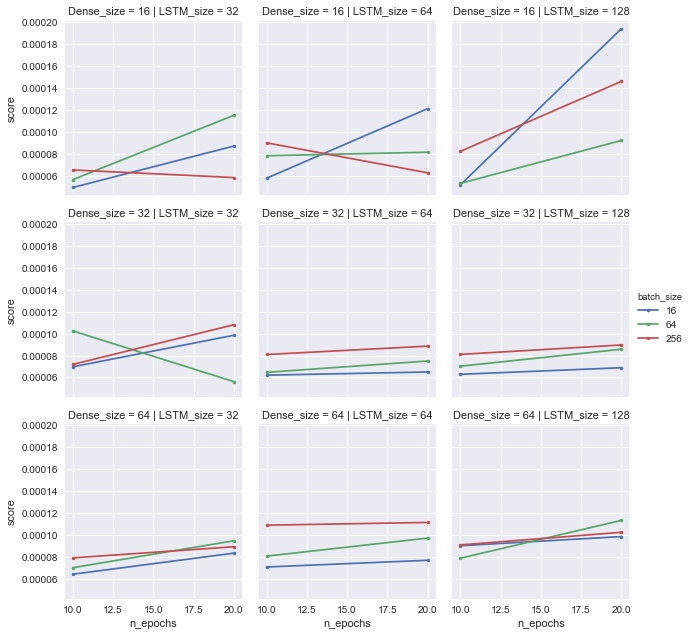

In [123]:
# _ show the results of the grid search
# df.to_csv("grid_scores.csv")

import seaborn as sns
g = sns.FacetGrid(df, row='Dense_size', col="LSTM_size", hue="batch_size")
g.map(plt.plot, "n_epochs", "score", marker=".").add_legend()
plt.show()

Build the best model according to the search

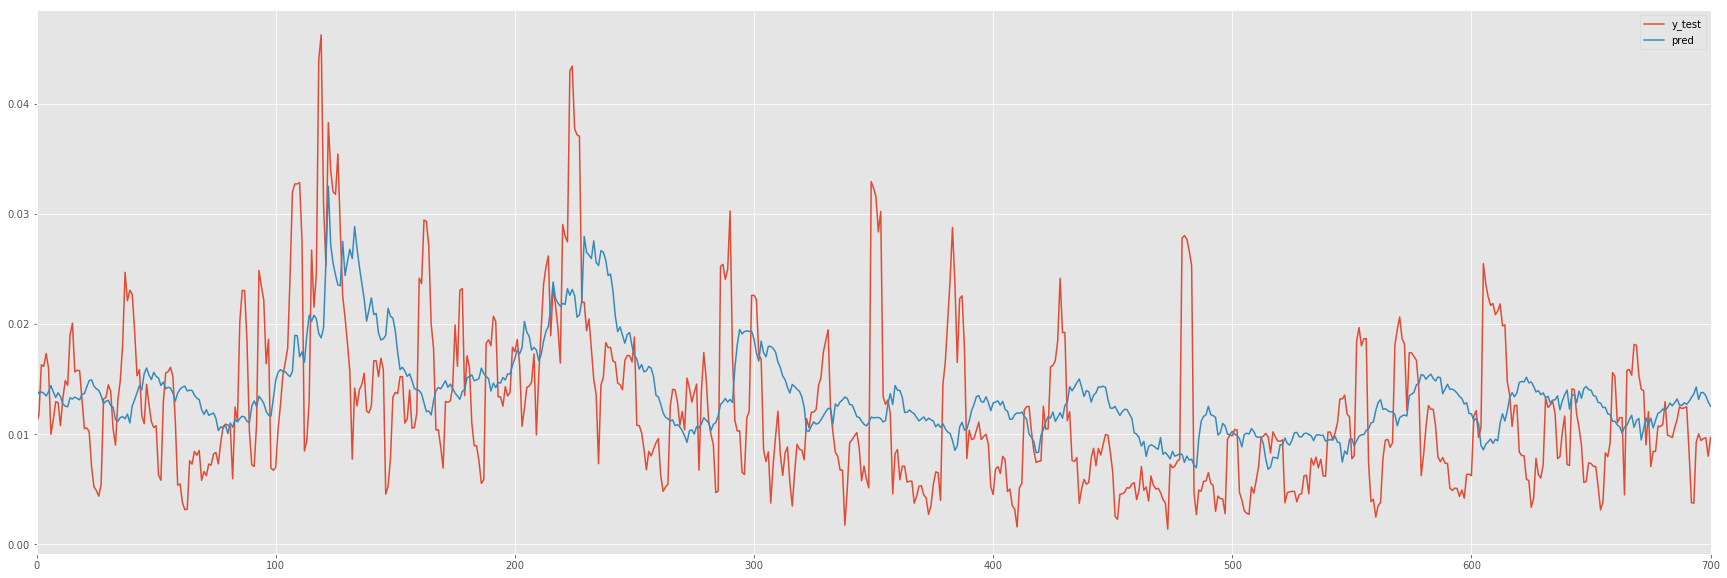

In [98]:
model = Sequential()
model.add(LSTM(32, input_shape=_data_shape, return_sequences=False))
model.add(Dropout(d))
model.add(Dense(16, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))

opt = Nadam(lr=0.002, clipnorm = .1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="model_returns.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=opt, loss='mse')

model.load_weights("LSTM_size32_Dense_size16_batch_size16_epochs10.hdf5")
y_pred = model.predict(x_test)
pred_df = pd.DataFrame(np.column_stack([y_test, y_pred]), columns=["y_test", "pred"])

# _ show results
pred_df.plot()
plt.show()

2-Layer LSTM

In [104]:
model = Sequential()
model.add(LSTM(32, input_shape=_data_shape, return_sequences=True))
model.add(LSTM(32, input_shape=_data_shape, return_sequences=False))
model.add(Dropout(d))
model.add(Dense(16, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))

opt = Nadam(lr=0.002, clipnorm = .1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="model_stacked_2.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=opt, loss='mse')

In [105]:
history = model.fit(x_train,
                    y_train,
                    batch_size=16,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[reduce_lr, checkpointer],
                    verbose=1)

Train on 5675 samples, validate on 631 samples
Epoch 1/10
5675/5675 [==============================] - 78s 14ms/step - loss: 2.7538e-04 - val_loss: 1.1332e-04
Epoch 2/10
5675/5675 [==============================] - 64s 11ms/step - loss: 2.5402e-04 - val_loss: 1.6255e-04
Epoch 3/10
5675/5675 [==============================] - 64s 11ms/step - loss: 2.4880e-04 - val_loss: 8.8473e-05
Epoch 4/10
5675/5675 [==============================] - 64s 11ms/step - loss: 2.4481e-04 - val_loss: 2.4179e-04
Epoch 5/10
5675/5675 [==============================] - 62s 11ms/step - loss: 2.4397e-04 - val_loss: 9.0671e-05
Epoch 6/10
5675/5675 [==============================] - 64s 11ms/step - loss: 2.4186e-04 - val_loss: 6.6212e-05
Epoch 7/10
5675/5675 [==============================] - 63s 11ms/step - loss: 2.4053e-04 - val_loss: 7.5363e-05
Epoch 8/10
5675/5675 [==============================] - 64s 11ms/step - loss: 2.3835e-04 - val_loss: 1.0854e-04
Epoch 9/10
5675/5675 [==============================] - 6

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=16)

model.load_weights("model_stacked_2.hdf5")
y_pred = model.predict(x_test)

pred_df = pd.DataFrame(np.column_stack([y_test, y_pred]), columns=["y_test", "pred"])

# _ show results
pred_df.plot(title="MSE: {}".format(score))
plt.show()

3-Layer LSTM

In [108]:
model = Sequential()
model.add(LSTM(32, input_shape=_data_shape, return_sequences=True))
model.add(LSTM(32, input_shape=_data_shape, return_sequences=True))
model.add(LSTM(32, input_shape=_data_shape, return_sequences=False))
model.add(Dropout(d))
model.add(Dense(16, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))

opt = Nadam(lr=0.002, clipnorm = .1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="model_stacked_3.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=opt, loss='mse')

In [109]:
history = model.fit(x_train,
                    y_train,
                    batch_size=16,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[reduce_lr, checkpointer],
                    verbose=1)

Train on 5675 samples, validate on 631 samples
Epoch 1/10
5675/5675 [==============================] - 104s 18ms/step - loss: 2.8240e-04 - val_loss: 1.6226e-04
Epoch 2/10
5675/5675 [==============================] - 90s 16ms/step - loss: 2.6138e-04 - val_loss: 1.8240e-04
Epoch 3/10
5675/5675 [==============================] - 89s 16ms/step - loss: 2.5365e-04 - val_loss: 1.0497e-04
Epoch 4/10
5675/5675 [==============================] - 90s 16ms/step - loss: 2.4935e-04 - val_loss: 1.3065e-04
Epoch 5/10
5675/5675 [==============================] - 89s 16ms/step - loss: 2.4559e-04 - val_loss: 7.5147e-05
Epoch 6/10
5675/5675 [==============================] - 90s 16ms/step - loss: 2.4344e-04 - val_loss: 8.6439e-05
Epoch 7/10
5675/5675 [==============================] - 90s 16ms/step - loss: 2.4162e-04 - val_loss: 8.2285e-05
Epoch 8/10
5675/5675 [==============================] - 89s 16ms/step - loss: 2.3967e-04 - val_loss: 8.2433e-05
Epoch 9/10
5675/5675 [==============================] - 

701/701 [==============================] - 2s 3ms/step


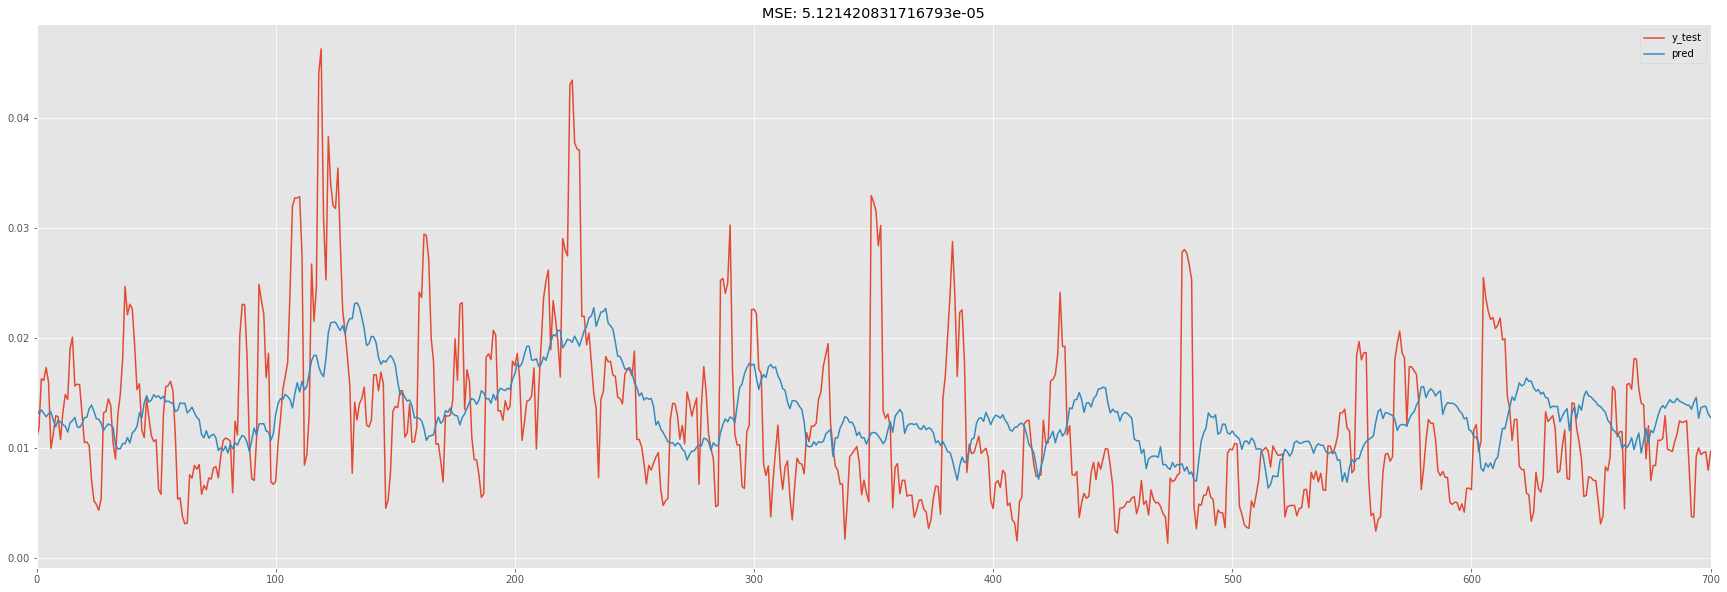

In [111]:
score = model.evaluate(x_test, y_test, batch_size=16)

model.load_weights("model_stacked_3.hdf5")
y_pred = model.predict(x_test)

pred_df = pd.DataFrame(np.column_stack([y_test, y_pred]), columns=["y_test", "pred"])

# _ show results
pred_df.plot(title="MSE: {}".format(score))
plt.show()

In [112]:
score

5.1214208317167933e-05

Truncate input

In [118]:
short_input_data = input_data["2000-1-1":]

short_X = short_input_data[['AdjOpen', 'AdjHigh', 'AdjLow', 'AdjClose', 'AdjVolume', 'ex_post_volatility']]
short_Y = short_input_data['ex_ante_volatility']

def normalize_data(X, Y, LOOKBACK_WINDOW):
    _X = X.dropna()
    _Xs = []
    _Ys = []
    for i in range(_X.shape[0] - LOOKBACK_WINDOW):
        cur_X = _X.values[i:i + LOOKBACK_WINDOW]
        _Xs.append(cur_X)
        
        y_pointer = i + LOOKBACK_WINDOW
        cur_Y = Y.values[y_pointer]
        _Ys.append(cur_Y)
    return np.array(_Xs), np.array(_Ys)

short_x, short_y = normalize_data(short_X, short_Y, 30)

short_x_train, short_x_test = short_x[:int(len(short_x) * .9)], short_x[int(len(short_x) * .9):]
short_y_train, short_y_test = short_y[:int(len(short_y) * .9)], short_y[int(len(short_y) * .9):]

In [116]:
model = Sequential()
model.add(LSTM(32, input_shape=_data_shape, return_sequences=False))
model.add(Dropout(d))
model.add(Dense(16, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))

opt = Nadam(lr=0.002, clipnorm = .1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="model_short.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=opt, loss='mse')

In [119]:
history = model.fit(short_x_train,
                    short_y_train,
                    batch_size=16,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[reduce_lr, checkpointer],
                    verbose=1)

Train on 3631 samples, validate on 404 samples
Epoch 1/10
3631/3631 [==============================] - 41s 11ms/step - loss: 2.4448e-04 - val_loss: 5.5456e-05
Epoch 2/10
3631/3631 [==============================] - 25s 7ms/step - loss: 2.0468e-04 - val_loss: 1.2725e-04
Epoch 3/10
3631/3631 [==============================] - 25s 7ms/step - loss: 2.0144e-04 - val_loss: 6.3055e-05
Epoch 4/10
3631/3631 [==============================] - 25s 7ms/step - loss: 1.9894e-04 - val_loss: 7.2927e-05
Epoch 5/10
3631/3631 [==============================] - 25s 7ms/step - loss: 1.9689e-04 - val_loss: 9.8272e-05
Epoch 6/10
3631/3631 [==============================] - 25s 7ms/step - loss: 1.9658e-04 - val_loss: 6.2341e-05
Epoch 7/10
3631/3631 [==============================] - 25s 7ms/step - loss: 1.9551e-04 - val_loss: 5.3718e-05
Epoch 8/10
3631/3631 [==============================] - 25s 7ms/step - loss: 1.9338e-04 - val_loss: 8.8289e-05
Epoch 9/10
3631/3631 [==============================] - 25s 7ms/

449/449 [==============================] - 1s 1ms/step


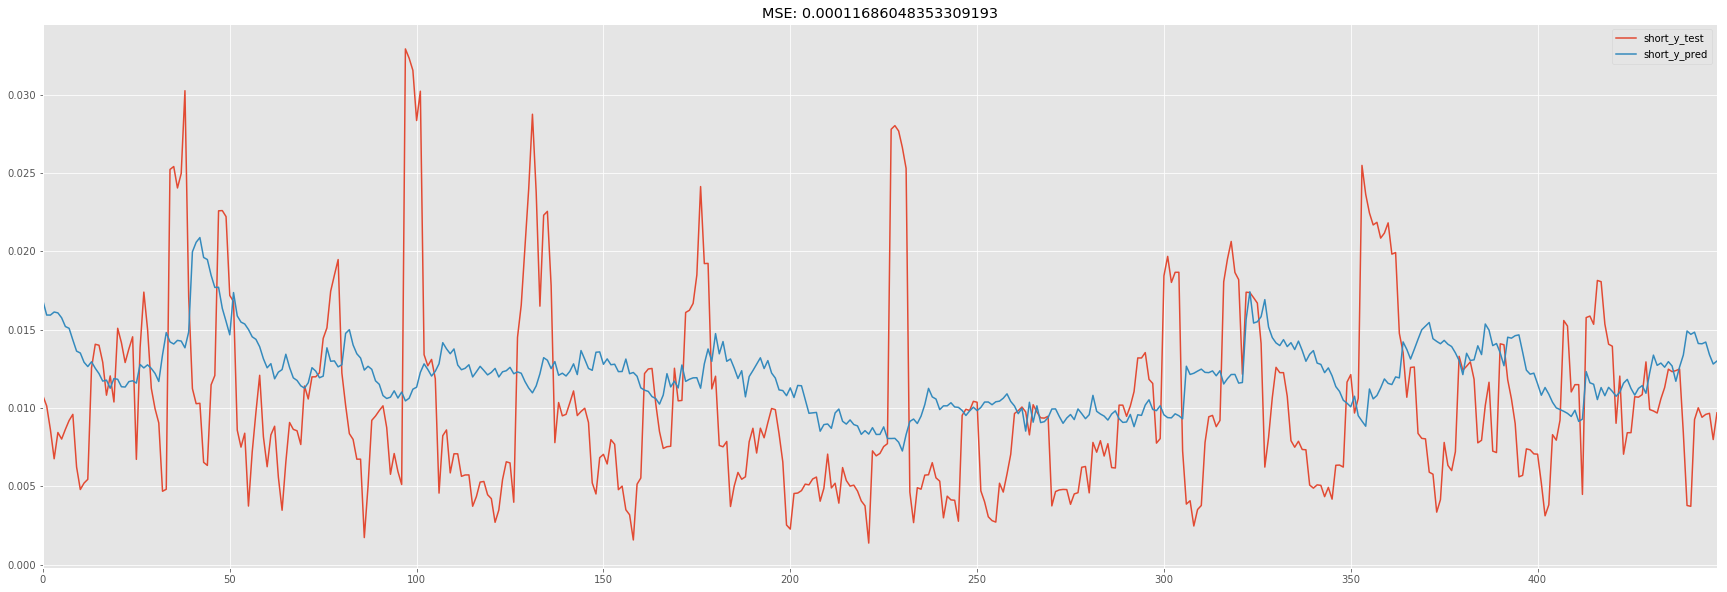

In [120]:
score = model.evaluate(short_x_test, short_y_test, batch_size=16)

model.load_weights("model_short.hdf5")
short_y_pred = model.predict(short_x_test)

pred_df = pd.DataFrame(np.column_stack([short_y_test, short_y_pred]), columns=["short_y_test", "short_y_pred"])

# _ show results
pred_df.plot(title="MSE: {}".format(score))
plt.show()

In [47]:
from IPython.core.display import display, HTML
display(HTML("<style> .container { width: 90% }; !important </style>"))